In [ ]:
import pandas as pd
import random
import torch
from pandas import read_excel
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras.models import model_from_json
import tensorflow as tf
from sklearn.utils import class_weight
from google.colab import drive

In [ ]:
import pickle
from pprint import pprint
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

In [ ]:
drive.mount("/content/gdrive")

tf.test.gpu_device_name()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


''

In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/"

In [ ]:
def seed_everything(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set as {seed}")

seed_everything(42)

Random seed set as 42


# **Preprocessing and Integrating Data**

---



In [ ]:
df_biospec = pd.read_csv(location + "biospecimen_masterDB.csv", sep=",")
print("Biospecimen")
print(len(df_biospec))
print(len(df_biospec.columns))
df_biospec.head()

Biospecimen
641
7


,PATNO,ABETA42,A_SYN,P_TAU,T_TAU,URATE,STATUS
0,3915.0,1119.375,1719.650,13.1200,158.350,237.000000,1
1,3914.0,614.150,1584.650,14.0825,174.325,270.285714,1
2,3838.0,746.900,1256.775,10.9825,137.050,234.571429,1
3,3819.0,612.020,1136.380,8.4880,109.100,231.875000,1
4,3900.0,511.280,1263.540,11.3980,145.260,400.666667,1


In [ ]:
df_clinical = pd.read_csv(location + "clinical_masterDB.csv", sep=",")
df_clinical = df_clinical.drop(columns = ["ENROLLDT", "RAHAWOPI", "SLEEPINESS", "DEPRESSION", "RBD_STATUS",
                                          "GENDER", "HISPLAT", "RAINDALS", "RAASIAN", "RABLACK", "RAWHITE", "RANOS",
                                          "MDS_UPDRS1", "MDS_UPDRS2", "MDS_UPDRS3", "MOCA","Unadjusted_MOCA", "TREMOR", "PIGD"],
                               axis = 1)
print("Cinical")
print(len(df_clinical))
print(len(df_clinical.columns))
df_clinical.head()

Cinical
682
31


,PATNO,First_Fam_Num,First_Fam_PD,Other_Fam_Num,Other_Fam_PD,AGE,Socio_Score,BJLO,ESS,GDS,...,SCOPA_GASTRO,SCOPA_URINARY,SCOPA_CARDIO,SCOPA_THERMO,SCOPA_PUPIL,SCOPA_SEXUAL,SFT,STAI,UPSIT,STATUS
0,3000.0,5.0,0.0,12.0,0.0,69,18.0,14.250000,5.000000,0.500000,...,0.625000,3.750000,0.000000,0.000000,0.000000,1.750000,56.500000,60.625000,35.0,0
1,3001.0,6.0,0.0,15.5,0.0,65,16.0,14.250000,5.888889,1.666667,...,2.555556,6.888889,0.555556,1.000000,0.111111,4.333333,46.875000,61.666667,21.0,1
2,3002.0,6.0,0.0,16.0,0.0,67,16.0,12.625000,13.666667,5.333333,...,8.111111,7.777778,0.222222,4.666667,2.555556,1.222222,46.125000,79.222222,14.5,1
3,3003.0,4.0,0.0,6.0,0.0,56,16.0,13.375000,7.333333,1.111111,...,2.666667,9.888889,1.777778,0.888889,0.222222,0.111111,46.875000,47.111111,18.5,1
4,3004.0,5.0,0.0,8.0,0.0,59,16.0,14.142857,8.285714,1.000000,...,1.571429,2.857143,0.000000,0.714286,0.000000,1.428571,53.571429,54.285714,37.5,0


In [ ]:
df_genetic = pd.read_csv(location + "snp_masterDB.csv", sep=",")

features_file_path = location + "Genetic/feaSel_xgb_Genetic.txt"
# features_file_path = location + "feaSel_xgb_Genetic.txt"
with open(features_file_path, 'r') as file:
    feaSel_xgb = [line.strip() for line in file.readlines()]

# Retain only XGBoost Features
retain_list = list(feaSel_xgb)

all_columns = df_genetic.columns
drop_list = []
for i in all_columns:
  if(i not in retain_list and i != "STATUS" and i != "PATNO"):
    drop_list.append(i)

df_genetic = df_genetic.drop(columns = drop_list, axis = 1)
df_genetic.head()
print("features =", len(retain_list))

print(len(df_genetic))
print(len(df_genetic.columns))
df_genetic.head()

features = 154
733
156


,PATNO,chr4_90753960_C_T,chr4_90760221_A_C,chr4_90760828_C_T,chr1_20977221_A_T,chr1_20977449_G_T,chr1_20978058_G_A,chr4_90636193_T_C,chr4_90636708_T_C,chr4_90637010_A_G,...,chr4_90742815_G_A,chr4_90742861_T_G,chr4_90744216_G_A,chr4_90752205_T_C,chr6_109004379_C_T,chr17_44051846_A_G,chr4_90758389_G_C,chr17_44039691_A_G,chr10_47915898_A_G,STATUS
0,3627,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3509,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,3214,0,0,0,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,3556,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,3367,1,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
common_patno = set(df_clinical['PATNO']).intersection(df_biospec['PATNO'], df_genetic['PATNO'])
print(len(common_patno))

df_clinical = df_clinical[df_clinical['PATNO'].isin(common_patno)].copy()
df_biospec = df_biospec[df_biospec['PATNO'].isin(common_patno)].copy()
df_genetic = df_genetic[df_genetic['PATNO'].isin(common_patno)].copy()

df_clinical = df_clinical.sort_values(by='PATNO').reset_index(drop=True)
df_biospec = df_biospec.sort_values(by='PATNO').reset_index(drop=True)
df_genetic = df_genetic.sort_values(by='PATNO').reset_index(drop=True)

print("Dimensions of df_clinical:", df_clinical.shape)
print("Dimensions of df_biospec:", df_biospec.shape)
print("Dimensions of df_genetic:", df_genetic.shape)

598
Dimensions of df_clinical: (598, 31)
Dimensions of df_biospec: (598, 7)
Dimensions of df_genetic: (598, 156)


In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/Late_Integration/"

In [ ]:
X_clinical = df_clinical.drop(columns=['PATNO', 'STATUS']).values
X_biospec = df_biospec.drop(columns=['PATNO', 'STATUS']).values
X_genetic = df_genetic.drop(columns=['PATNO', 'STATUS']).values

print("Dimensions of X_clinical:", X_clinical.shape)
print("Dimensions of X_biospec:", X_biospec.shape)
print("Dimensions of X_genetic:", X_genetic.shape)

y = df_clinical['STATUS'].values
print("Length of y:", len(y))

print("Saving values")

np.save(location + 'X_clinical.npy', X_clinical)
np.save(location + 'X_biospec.npy', X_biospec)
np.save(location + 'X_genetic.npy', X_genetic)
np.save(location + 'y.npy', y)

# X_clinical = np.load(location + 'X_clinical.npy')
# X_biospec = np.load(location + 'X_biospec.npy')
# X_genetic = np.load(location + 'X_genetic.npy')
# y = np.load(location + 'y.npy')

Dimensions of X_clinical: (598, 29)
Dimensions of X_biospec: (598, 5)
Dimensions of X_genetic: (598, 154)
Length of y: 598
Saving values


In [ ]:
from sklearn.model_selection import train_test_split

X_clinical_train, X_clinical_test, X_biospec_train, X_biospec_test, X_genetic_train, X_genetic_test, y_train, y_test = train_test_split(
    X_clinical, X_biospec, X_genetic, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
scaler_clinical = StandardScaler()
scaler_biospec = StandardScaler()
scaler_genetic = StandardScaler()

X_clinical_train = scaler_clinical.fit_transform(X_clinical_train)
X_clinical_test = scaler_clinical.transform(X_clinical_test)

X_biospec_train = scaler_biospec.fit_transform(X_biospec_train)
X_biospec_test = scaler_biospec.transform(X_biospec_test)

X_genetic_train = scaler_genetic.fit_transform(X_genetic_train)
X_genetic_test = scaler_genetic.transform(X_genetic_test)

# **Loading the Best Model for each Modality**


## **Clinical - LightGBM**

In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/Clinical/"
filename = location + 'clin_lgbm' + '.sav'
clf_clin = pickle.load(open(filename, 'rb'))
print(clf_clin)

LGBMClassifier(class_weight={0: 0.7671428571428571, 1: 0.23285714285714287},
               colsample_bytree=0.7222222222222222,
               learning_rate=0.11999999999999998, max_depth=10, n_estimators=50,
               num_leaves=120, reg_alpha=0.04281332398719392,
               reg_lambda=0.0003359818286283781, subsample=0.7222222222222222)


## **Genetic - MLP**

In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/Genetic/"
filename = location + 'genetic_mlp.sav'
clf_genetic = pickle.load(open(filename, 'rb'))
print(clf_genetic)

MLPClassifier(alpha=0.3727593720314938, batch_size=128, early_stopping=True,
              hidden_layer_sizes=(51,), learning_rate_init=0.0001, max_iter=500,
              momentum=0.8374999999999999, n_iter_no_change=5, random_state=42,
              solver='sgd')


## **Biospecimen - Gaussian NB**

In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/Biospecimen/"
filename = location + 'biospec_GNB' + '.sav'
clf_biospec = pickle.load(open(filename, 'rb'))
print(clf_biospec)

GaussianNB(var_smoothing=0.12067926406393285)


# **Late Integration Model**


In [ ]:
location = "/content/gdrive/My Drive/MultiModal_PD/Late_Integration/"

In [ ]:
def get_individual_predictions(X_list, clf_clin, clf_genetic, clf_biospec):
    X_clinical, X_biospec, X_genetic = X_list
    pred_clin = clf_clin.predict_proba(X_clinical)[:, 1]
    pred_genetic = clf_genetic.predict_proba(X_genetic)[:, 1]
    pred_biospec = clf_biospec.predict_proba(X_biospec)[:, 1]
    return np.column_stack((pred_clin, pred_genetic, pred_biospec))

In [ ]:
X_train = [X_clinical_train, X_biospec_train, X_genetic_train]
X_test = [X_clinical_test, X_biospec_test, X_genetic_test]

X_train_preds = get_individual_predictions(X_train, clf_clin, clf_genetic, clf_biospec)
X_test_preds = get_individual_predictions(X_test, clf_clin, clf_genetic, clf_biospec)

print(X_train_preds.shape)
print(X_test_preds.shape)

(478, 3)
(120, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


In [ ]:
from sklearn.metrics import make_scorer

def custom_scorer(y_true, y_pred):
    f1_neg = f1_score(y_true, y_pred, pos_label=0)
    f1_pos = f1_score(y_true, y_pred, pos_label=1)
    return (f1_neg + f1_pos) / 2

custom_scorer = make_scorer(custom_scorer)

## **Random Forest**

In [ ]:
clf_rf = RandomForestClassifier(random_state=42)

# Hyperparameter space for Random Forest
rf_params = {
    'n_estimators': np.arange(100, 1000, 100),
    'bootstrap': [True, False],
    'warm_start': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(np.arange(10, 110, 10)),
    'min_samples_split': np.arange(2, 12, 2),
    'min_samples_leaf': np.arange(1, 11, 2),
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# RandomizedSearchCV for Random Forest
rf_random_search = RandomizedSearchCV(clf_rf, param_distributions=rf_params, n_iter=100, cv=StratifiedKFold(n_splits=5),
                                      verbose=2, scoring=custom_scorer, n_jobs=-1, random_state=42)

print("Starting Random Forest hyperparameter tuning...")
rf_random_search.fit(X_train_preds, y_train)

print("Best Random Forest parameters:")
print(rf_random_search.best_params_)

best_rf = rf_random_search.best_estimator_

with open(location + 'late_integration_rf.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

Starting Random Forest hyperparameter tuning...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
165 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils

Best Random Forest parameters:
{'warm_start': False, 'n_estimators': 400, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 'log2', 'max_depth': 50, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}


Evaluation for Random Forest:
AUC-ROC = 0.8906
AUC-PR = 0.9590
F1 score = 0.8736
Precision = 0.8636
Recall = 0.8837
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        34
           1       0.86      0.88      0.87        86

    accuracy                           0.82       120
   macro avg       0.78      0.77      0.77       120
weighted avg       0.81      0.82      0.81       120



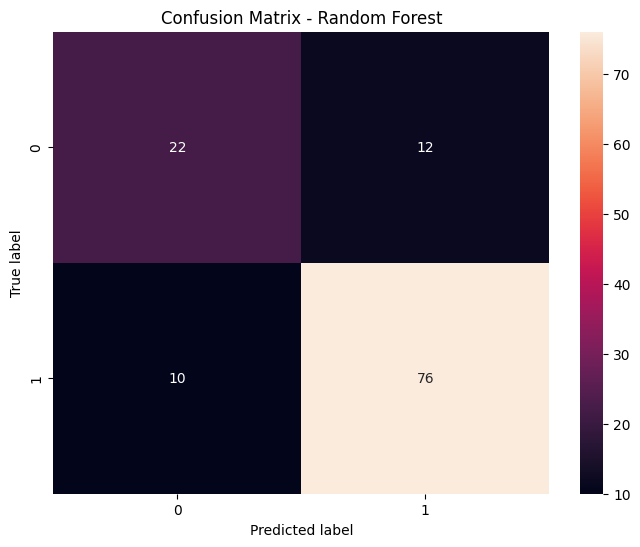

In [ ]:
y_pred_rf = best_rf.predict(X_test_preds)
y_pred_proba_rf = best_rf.predict_proba(X_test_preds)[:, 1]

print("Evaluation for Random Forest:")
print(f"AUC-ROC = {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print(f"AUC-PR = {average_precision_score(y_test, y_pred_proba_rf):.4f}")
print(f"F1 score = {f1_score(y_test, y_pred_rf):.4f}")
print(f"Precision = {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall = {recall_score(y_test, y_pred_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

cf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_rf, annot=True, fmt='d')
plt.title("Confusion Matrix - Random Forest")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Random Forest Classifier:
RandomForestClassifier(max_depth=50, max_features='log2', min_samples_leaf=9,
                       min_samples_split=4, n_estimators=400, random_state=42)


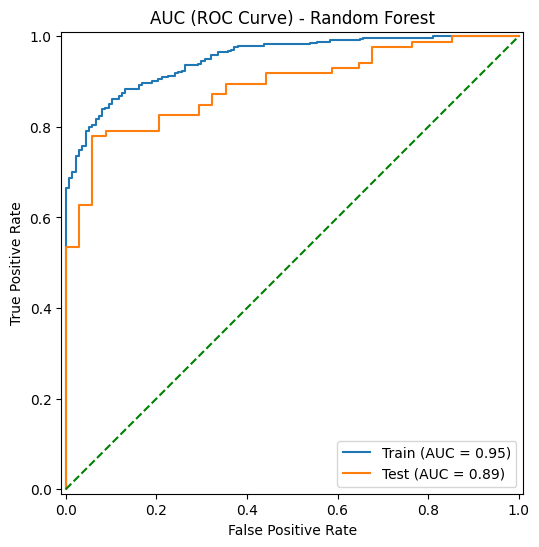

In [ ]:
print("Random Forest Classifier:")
print(best_rf)

fig, ax = plt.subplots(figsize=(8, 6))
X_list = [X_train_preds, X_test_preds]
y_list = [y_train, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    RocCurveDisplay.from_estimator(best_rf, X_list[i], y_list[i], name=name_list[i], ax=ax)

plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Random Forest")
plt.show()

## **Voting Classifier**

In [ ]:
voting_clf = VotingClassifier(estimators=[
    ('clinical', clf_clin),
    ('genetic', clf_genetic),
    ('biospecimen', clf_biospec)
], voting='soft')

# Hyperparameter space for Voting Classifier
voting_params = {
    'weights': [[1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [2, 2, 1], [2, 1, 2], [1, 2, 2]],
    'voting': ['hard', 'soft'],
    'flatten_transform': [True, False]
}

# RandomizedSearchCV for Voting Classifier
voting_random_search = RandomizedSearchCV(voting_clf, param_distributions=voting_params, n_iter=5, cv=StratifiedKFold(n_splits=5),
                                          verbose=2, scoring='roc_auc', n_jobs=-1, random_state=42)

print("Starting Voting Classifier hyperparameter tuning...")
voting_random_search.fit(X_train_preds, y_train)

print("Best Voting Classifier parameters:")
print(voting_random_search.best_params_)

best_voting_clf = voting_random_search.best_estimator_

with open(location + 'late_integration_voting.pkl', 'wb') as f:
    pickle.dump(best_voting_clf, f)

Starting Voting Classifier hyperparameter tuning...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[LightGBM] [Info] Number of positive: 341, number of negative: 137
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 460
[LightGBM] [Info] Number of data points in the train set: 478, number of used features: 3
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.430369 -> initscore=-0.280346
[LightGBM] [Info] Start training from score -0.280346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.89994785 0.89408917 0.89419653 0.90025677        nan]
  warnings.warn(


Evaluation for Voting Classifier:
AUC-ROC = 0.8663
AUC-PR = 0.9528
F1 score = 0.8428
Precision = 0.9178
Recall = 0.7791
              precision    recall  f1-score   support

           0       0.60      0.82      0.69        34
           1       0.92      0.78      0.84        86

    accuracy                           0.79       120
   macro avg       0.76      0.80      0.77       120
weighted avg       0.83      0.79      0.80       120



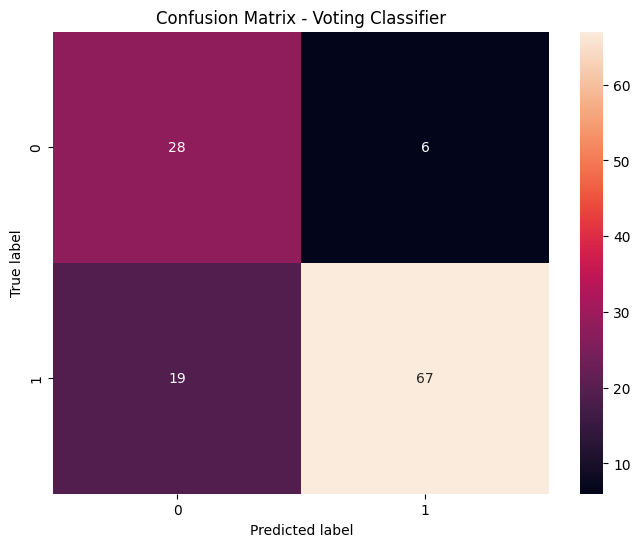

In [ ]:
y_pred_vc = best_voting_clf.predict(X_test_preds)
y_pred_proba_vc = best_voting_clf.predict_proba(X_test_preds)[:, 1]

print("Evaluation for Voting Classifier:")
print(f"AUC-ROC = {roc_auc_score(y_test, y_pred_proba_vc):.4f}")
print(f"AUC-PR = {average_precision_score(y_test, y_pred_proba_vc):.4f}")
print(f"F1 score = {f1_score(y_test, y_pred_vc):.4f}")
print(f"Precision = {precision_score(y_test, y_pred_vc):.4f}")
print(f"Recall = {recall_score(y_test, y_pred_vc):.4f}")
print(classification_report(y_test, y_pred_vc))

cf_matrix_vc = confusion_matrix(y_test, y_pred_vc)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_vc, annot=True, fmt='d')
plt.title("Confusion Matrix - Voting Classifier")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Voting Classifier:
VotingClassifier(estimators=[('clinical',
                              LGBMClassifier(class_weight={0: 0.7671428571428571,
                                                           1: 0.23285714285714287},
                                             colsample_bytree=0.7222222222222222,
                                             learning_rate=0.11999999999999998,
                                             max_depth=10, n_estimators=50,
                                             num_leaves=120,
                                             reg_alpha=0.04281332398719392,
                                             reg_lambda=0.0003359818286283781,
                                             subsample=0.7222222222222222)),
                             ('genetic',
                              MLPClassifier(alpha=0.3727593720314938,
                                            batch_size=128, early_stopping=True,
                                            hidden

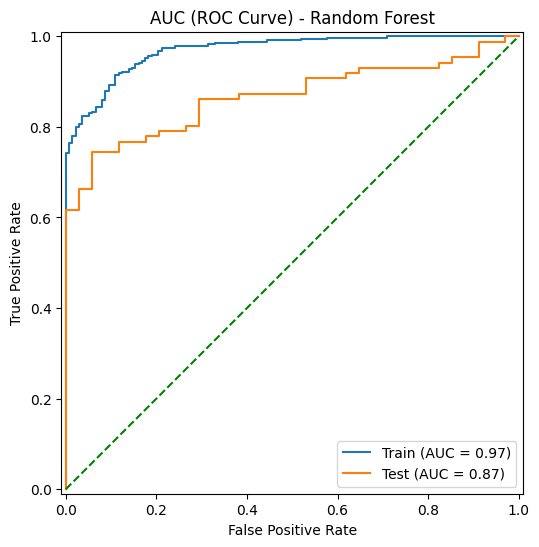

In [ ]:
print("Voting Classifier:")
print(best_voting_clf)

fig, ax = plt.subplots(figsize=(8, 6))
X_list = [X_train_preds, X_test_preds]
y_list = [y_train, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    RocCurveDisplay.from_estimator(best_voting_clf, X_list[i], y_list[i], name=name_list[i], ax=ax)

plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Random Forest")
plt.show()

## **Stacking Classifier**

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
stacking_clf = StackingClassifier(
    estimators= [
        ('clinical', clf_clin),
        ('genetic', clf_genetic),
        ('biospecimen', clf_biospec)
        ],
    final_estimator=LogisticRegression(),
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)

stacking_params = {
    'final_estimator__C': np.logspace(-4, 4, 10),
    'final_estimator__solver': ['liblinear', 'saga'],
    'final_estimator__penalty': ['l1', 'l2'],
    'final_estimator__max_iter': [100, 200, 300]
}

# RandomizedSearchCV for Stacking Classifier
stacking_random_search = RandomizedSearchCV(
    stacking_clf,
    param_distributions=stacking_params,
    n_iter=10,
    cv=StratifiedKFold(n_splits=5),
    verbose=2,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

print("Starting Stacking Classifier hyperparameter tuning...")
stacking_random_search.fit(X_train_preds, y_train)

print("Best Stacking Classifier parameters:")
print(stacking_random_search.best_params_)

best_stacking = stacking_random_search.best_estimator_

with open(location + 'late_integration_stacking.pkl', 'wb') as f:
    pickle.dump(best_stacking, f)

Starting Stacking Classifier hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Stacking Classifier parameters:
{'final_estimator__solver': 'saga', 'final_estimator__penalty': 'l2', 'final_estimator__max_iter': 200, 'final_estimator__C': 0.3593813663804626}


Evaluation for Stacking Classifier:
AUC-ROC = 0.8724
AUC-PR = 0.9553
F1 score = 0.8621
Precision = 0.8523
Recall = 0.8721
              precision    recall  f1-score   support

           0       0.66      0.62      0.64        34
           1       0.85      0.87      0.86        86

    accuracy                           0.80       120
   macro avg       0.75      0.74      0.75       120
weighted avg       0.80      0.80      0.80       120



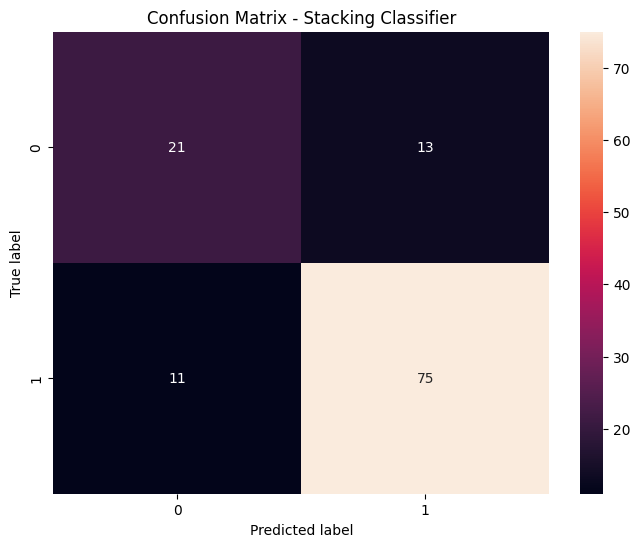

In [ ]:
y_pred_stacking = best_stacking.predict(X_test_preds)
y_pred_proba_stacking = best_stacking.predict_proba(X_test_preds)[:, 1]

print("Evaluation for Stacking Classifier:")
print(f"AUC-ROC = {roc_auc_score(y_test, y_pred_proba_stacking):.4f}")
print(f"AUC-PR = {average_precision_score(y_test, y_pred_proba_stacking):.4f}")
print(f"F1 score = {f1_score(y_test, y_pred_stacking):.4f}")
print(f"Precision = {precision_score(y_test, y_pred_stacking):.4f}")
print(f"Recall = {recall_score(y_test, y_pred_stacking):.4f}")
print(classification_report(y_test, y_pred_stacking))

cf_matrix_stacking = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_stacking, annot=True, fmt='d')
plt.title("Confusion Matrix - Stacking Classifier")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Stacking Classifier:
StackingClassifier(cv=StratifiedKFold(n_splits=5,
        random_state=RandomState(MT19937) at 0x7A8054F02E40, shuffle=False),
                   estimators=[('clinical',
                                LGBMClassifier(class_weight={0: 0.7671428571428571,
                                                             1: 0.23285714285714287},
                                               colsample_bytree=0.7222222222222222,
                                               learning_rate=0.11999999999999998,
                                               max_depth=10, n_estimators=50,
                                               num_leaves=120,
                                               reg_alpha=0.0428133239871...
                                MLPClassifier(alpha=0.3727593720314938,
                                              batch_size=128,
                                              early_stopping=True,
                                              hidden_l

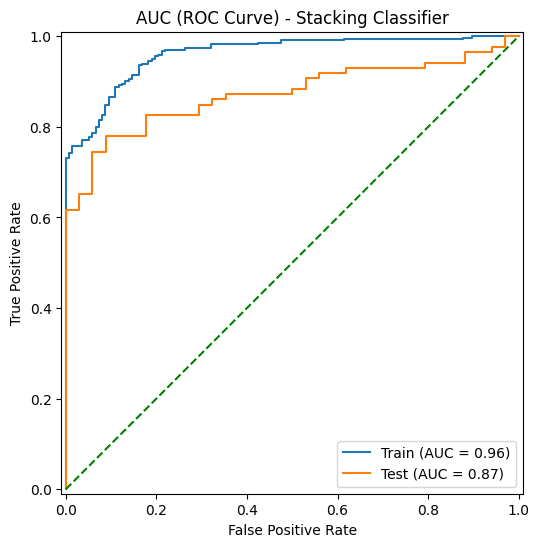

In [ ]:
print("Stacking Classifier:")
print(best_stacking)

fig, ax = plt.subplots(figsize=(8, 6))
X_list = [X_train_preds, X_test_preds]
y_list = [y_train, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    RocCurveDisplay.from_estimator(best_stacking, X_list[i], y_list[i], name=name_list[i], ax=ax)

plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - Stacking Classifier")
plt.show()

## **XGBoost Classifier**

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb_clf = XGBClassifier(random_state=42)

# Hyperparameter space for XGBoost
xgb_params = {
    'n_estimators': np.arange(100, 1000, 100),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': np.arange(3, 15),
    'min_child_weight': np.arange(1, 10),
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3]
}

# RandomizedSearchCV for XGBoost Classifier
xgb_random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=xgb_params,
    n_iter=100,
    cv=StratifiedKFold(n_splits=5),
    verbose=2,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)

print("Starting XGBoost hyperparameter tuning...")
xgb_random_search.fit(X_train_preds, y_train)

print("Best XGBoost parameters:")
print(xgb_random_search.best_params_)

best_xgb = xgb_random_search.best_estimator_

with open(location + 'late_integration_xgb.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

Starting XGBoost hyperparameter tuning...
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best XGBoost parameters:
{'subsample': 0.5, 'n_estimators': 300, 'min_child_weight': 6, 'max_depth': 12, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.75}


Evaluation for XGBoost Classifier:
AUC-ROC = 0.8919
AUC-PR = 0.9605
F1 score = 0.8750
Precision = 0.8556
Recall = 0.8953
              precision    recall  f1-score   support

           0       0.70      0.62      0.66        34
           1       0.86      0.90      0.88        86

    accuracy                           0.82       120
   macro avg       0.78      0.76      0.77       120
weighted avg       0.81      0.82      0.81       120



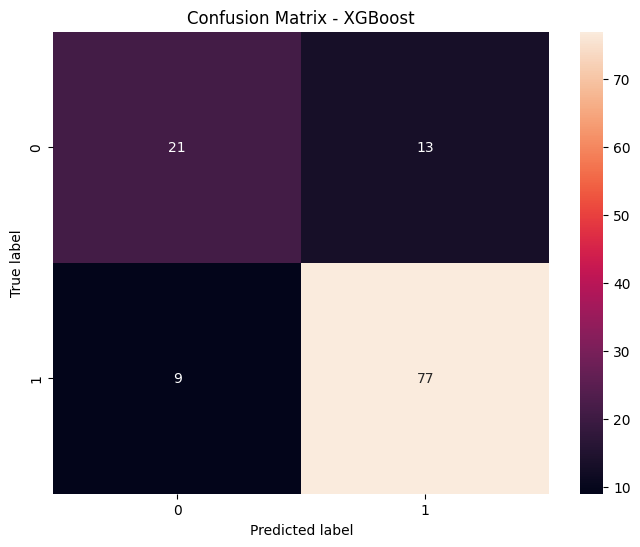

In [ ]:
y_pred_xgb = best_xgb.predict(X_test_preds)
y_pred_proba_xgb = best_xgb.predict_proba(X_test_preds)[:, 1]

print("Evaluation for XGBoost Classifier:")
print(f"AUC-ROC = {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print(f"AUC-PR = {average_precision_score(y_test, y_pred_proba_xgb):.4f}")
print(f"F1 score = {f1_score(y_test, y_pred_xgb):.4f}")
print(f"Precision = {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall = {recall_score(y_test, y_pred_xgb):.4f}")
print(classification_report(y_test, y_pred_xgb))

cf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix_xgb, annot=True, fmt='d')
plt.title("Confusion Matrix - XGBoost")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

XGBoost Classifier:
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


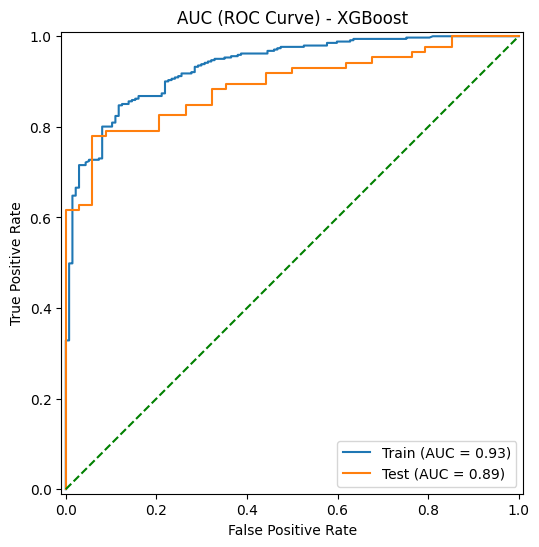

In [ ]:
print("XGBoost Classifier:")
print(best_xgb)

fig, ax = plt.subplots(figsize=(8, 6))
X_list = [X_train_preds, X_test_preds]
y_list = [y_train, y_test]
name_list = ["Train", "Test"]

for i in range(2):
    RocCurveDisplay.from_estimator(best_xgb, X_list[i], y_list[i], name=name_list[i], ax=ax)

plt.plot([0, 1], [0, 1], linestyle='--', color='green')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC (ROC Curve) - XGBoost")
plt.show()